In [ ]:
!pip install transformers

In [ ]:
!nvidia-smi

Sat Apr 30 22:50:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import json
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer, AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import Dataset, random_split
import torch

In [ ]:
torch.cuda.device_count()

1

In [ ]:
device = "cuda:0"

In [ ]:
# Path to the input data directory
input_data_dir = "/content/drive/MyDrive/NeuralNets/Project/data/"

In [ ]:
total_samples = 0
data = []
text_to_ignore = ["% continue here %"]
for fname in os.listdir(input_data_dir):
    if fname.endswith(".txt") and fname not in ["combined.txt"]:
      print("Processing file: ", fname)
      f_path = os.path.join(input_data_dir, fname)
      with open(f_path, "r") as fp:
        content = [sample for sample in fp.read().split('\n\n') if len(sample)>0 and sample not in text_to_ignore]
        print(f"File name: {fname}, # Samples: {len(content)}")
        total_samples += len(content)
        data.extend(content)

print(f"Total samples obtained: {total_samples}")

Processing file:  ash.txt
File name: ash.txt, # Samples: 46
Processing file:  christ.txt
File name: christ.txt, # Samples: 13
Processing file:  hornpipes.txt
File name: hornpipes.txt, # Samples: 65
Processing file:  jigs.txt
File name: jigs.txt, # Samples: 340
Processing file:  morris.txt
File name: morris.txt, # Samples: 31
Processing file:  mq.txt
File name: mq.txt, # Samples: 80
Processing file:  playford.txt
File name: playford.txt, # Samples: 15
Processing file:  reelsac.txt
File name: reelsac.txt, # Samples: 81
Processing file:  reelsdg.txt
File name: reelsdg.txt, # Samples: 84
Processing file:  reelshl.txt
File name: reelshl.txt, # Samples: 93
Processing file:  rt.txt
File name: rt.txt, # Samples: 92
Processing file:  slipjigs.txt
File name: slipjigs.txt, # Samples: 11
Processing file:  uz.txt
File name: uz.txt, # Samples: 34
Processing file:  waltzes.txt
File name: waltzes.txt, # Samples: 52
Total samples obtained: 1037


In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilgpt2', 
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Token indices sequence length is longer than the specified maximum sequence length for this model (1118 > 1024). Running this sequence through the model will result in indexing errors


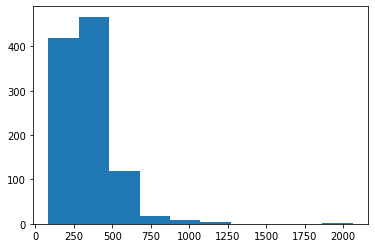

In [ ]:
import matplotlib.pyplot as plt

plt.hist([len(tokenizer.encode(sample)) for sample in data])
plt.show()

In [ ]:
max_length = 1024

In [ ]:
class MusicDataSet(Dataset):
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>' + txt[:1022] + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
# Initialize torch
dataset = MusicDataSet(data, tokenizer, 1024)

In [ ]:
# Train and Validation split
train_size = int(0.9 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

In [ ]:
# Initialize Model
model = AutoModelForCausalLM.from_pretrained('distilgpt2').cuda()
model.resize_token_embeddings(len(tokenizer))
# model.to(device)

Embedding(50259, 768)

In [ ]:
import gc
gc.collect()

3287

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Initialize Training Arguments
training_args = TrainingArguments(output_dir="./output", num_train_epochs=20, weight_decay=0.05, per_device_train_batch_size=1, per_device_eval_batch_size=1, warmup_steps=10)

In [ ]:
Trainer(
model=model,  
args=training_args, 
train_dataset=train_dataset, 
eval_dataset=val_dataset,
data_collator=lambda data: {
    'input_ids': torch.stack([f[0] for f in data]),
    'attention_mask': torch.stack([f[1] for f in data]),
    'labels': torch.stack([f[0] for f in data])}
).train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 933
  Num Epochs = 20
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 18660


Step,Training Loss
500,0.608100
1000,0.419200
1500,0.368500
2000,0.357000
2500,0.332800
3000,0.319300
3500,0.307300
4000,0.295100
4500,0.290900
5000,0.284300


Saving model checkpoint to ./output/checkpoint-500
Configuration saved in ./output/checkpoint-500/config.json
Model weights saved in ./output/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./output/checkpoint-1000
Configuration saved in ./output/checkpoint-1000/config.json
Model weights saved in ./output/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./output/checkpoint-1500
Configuration saved in ./output/checkpoint-1500/config.json
Model weights saved in ./output/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./output/checkpoint-2000
Configuration saved in ./output/checkpoint-2000/config.json
Model weights saved in ./output/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./output/checkpoint-2500
Configuration saved in ./output/checkpoint-2500/config.json
Model weights saved in ./output/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./output/checkpoint-3000
Configuration saved in ./output/checkpoint-3000/config.json
M

TrainOutput(global_step=18660, training_loss=0.25812703609977633, metrics={'train_runtime': 2574.9075, 'train_samples_per_second': 7.247, 'train_steps_per_second': 7.247, 'total_flos': 4875797366046720.0, 'train_loss': 0.25812703609977633, 'epoch': 20.0})

In [ ]:
generated = tokenizer("<|startoftext|> ", return_tensors="pt").input_ids.cuda()

In [ ]:
sample_outputs = model.generate(generated, do_sample=True, top_k=50, max_length=1024, top_p=0.95, temperature=1.9, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
    print("***********************************************************************")

0:   Super Lucky Day here in California
Kerrs/2E4
Taken by Jacquie
M:4/4
L:1/4
P:ABCB
P:A
D|B/2c/2"D7 [FA']|"G"G3/2d/2 GB|"F"Ac/2d -"Em"dd|c3d|"Ab dAz|
2a/2e/2e|e/2F df|AG FA|[ECA7]E2 F\
P:DA[FEFE ][2 A3/2B/2|
"D7"dz|c/2A/2F A|"Em"Ge B3/2F/2G/2|AG F#:3 [M:4/4L]F/4|\
"Em"GF E3c/2B,|"A7"(3AG/2F/2 EC|
"D7"GE =DC\
P :D.S.F |"G"gg f3/2e/2|"E7"(3GHD)DE|GE F^D|"C"cA ef|
"GA-"(c/2e/2d ga|^fac cAc|eB D^D|GA+=d|
M:3.48\
!=e|!sevent!P :D.S.D.F.C |
***********************************************************************
1:    'G'W3 - -U'z
P:Idolia Pet
T:Viper
% ABBA times 31
% Nottingham Music Database
S:O'Neils 1850 Bc+D|"O-"C"GEF DEF|"C"EFG "Babag"Bee|"G"de-fa b2g "G7"agf|
B7"gfg fee g2e|agf bag|efe dcB|ecA FA|fe dcA|
FA A,G,2A||B, EFG ||B,EE AGEC|[1 AG^FAE EFG:|2AGE
2|!-B^AB ^c^d=c|dBB ABBA (B^AceAc|G^F E=GG|[2 AGAB \
P:3.31
CAG |%P:3
FA DE|Edd ddd|=GeF de_de|Ac cdB|GA_B =BcAG|
^F EE_D|_FF f4-|AfE dcGA|
^F E=FF eee||FE4|\
P:Vigab af edc|GA_B2 A^G_G_||
********************************************

In [ ]:
# Save the model
trained_model_weight_path = input_data_dir + "trained_distillgpt2.h5"
torch.save(model, trained_model_weight_path)